In [1]:
import os, warnings
from pathlib import Path

import numpy as np
import dynamo as dyn
import pandas as pd
import spateo as st
import scanpy as sc
warnings.filterwarnings('ignore')

2023-09-14 13:28:04.965092: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-14 13:28:05.099445: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 13:28:05.581535: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load the data

In [2]:
sample_id = "E7_8h"
os.chdir(f"/media/pc001/Yao/Projects/Project_drosophila/Data_v4/migration-hotspot/drosophila_{sample_id}_germ_layer_new")
cpo = [(41, 1209, 57), (13, 8, -3), (0, 0, 1)]

out_image_path = f"image/amnioserosa_backbone"
Path(out_image_path).mkdir(parents=True, exist_ok=True)

In [3]:
germ_adata = st.read_h5ad(f"h5ad/{sample_id}_amnioserosa_v3.h5ad")
germ_pc = st.tdr.read_model(f"pc_models/Amnioserosa_{sample_id}_aligned_pc_model.vtk")
germ_adata

AnnData object with n_obs × n_vars = 769 × 6729
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'backbone_nodes', 'backbone_scc', 'segments'
    uns: '__type', 'glm_degs', 'log1p', 'pp'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

## generate backbone

In [120]:
## Calculate the Backbone of drosophila germ layer
st.tdr.add_model_labels(model=germ_pc, labels=["Amnioserosa Point Clouds"]*germ_pc.n_points, key_added="backbone", where="point_data",inplace=True, alphamap=0.4, colormap="gainsboro")
germ_mesh = st.tdr.read_model(f"mesh_models/Amnioserosa_{sample_id}_aligned_mesh_model.vtk")
germ_voxel, _ = st.tdr.voxelize_mesh(mesh=germ_mesh, voxel_pc=None, key_added="backbone", label="Voxel", color="gainsboro", smooth=100)
germ_voxel

UnstructuredGrid (0x7f008c493a00)
  N Cells:    26886
  N Points:   32977
  X Bounds:   -1.314e+02, 1.102e+02
  Y Bounds:   -7.813e+01, 1.056e+02
  Z Bounds:   -5.887e+01, 8.741e+01
  N Arrays:   4

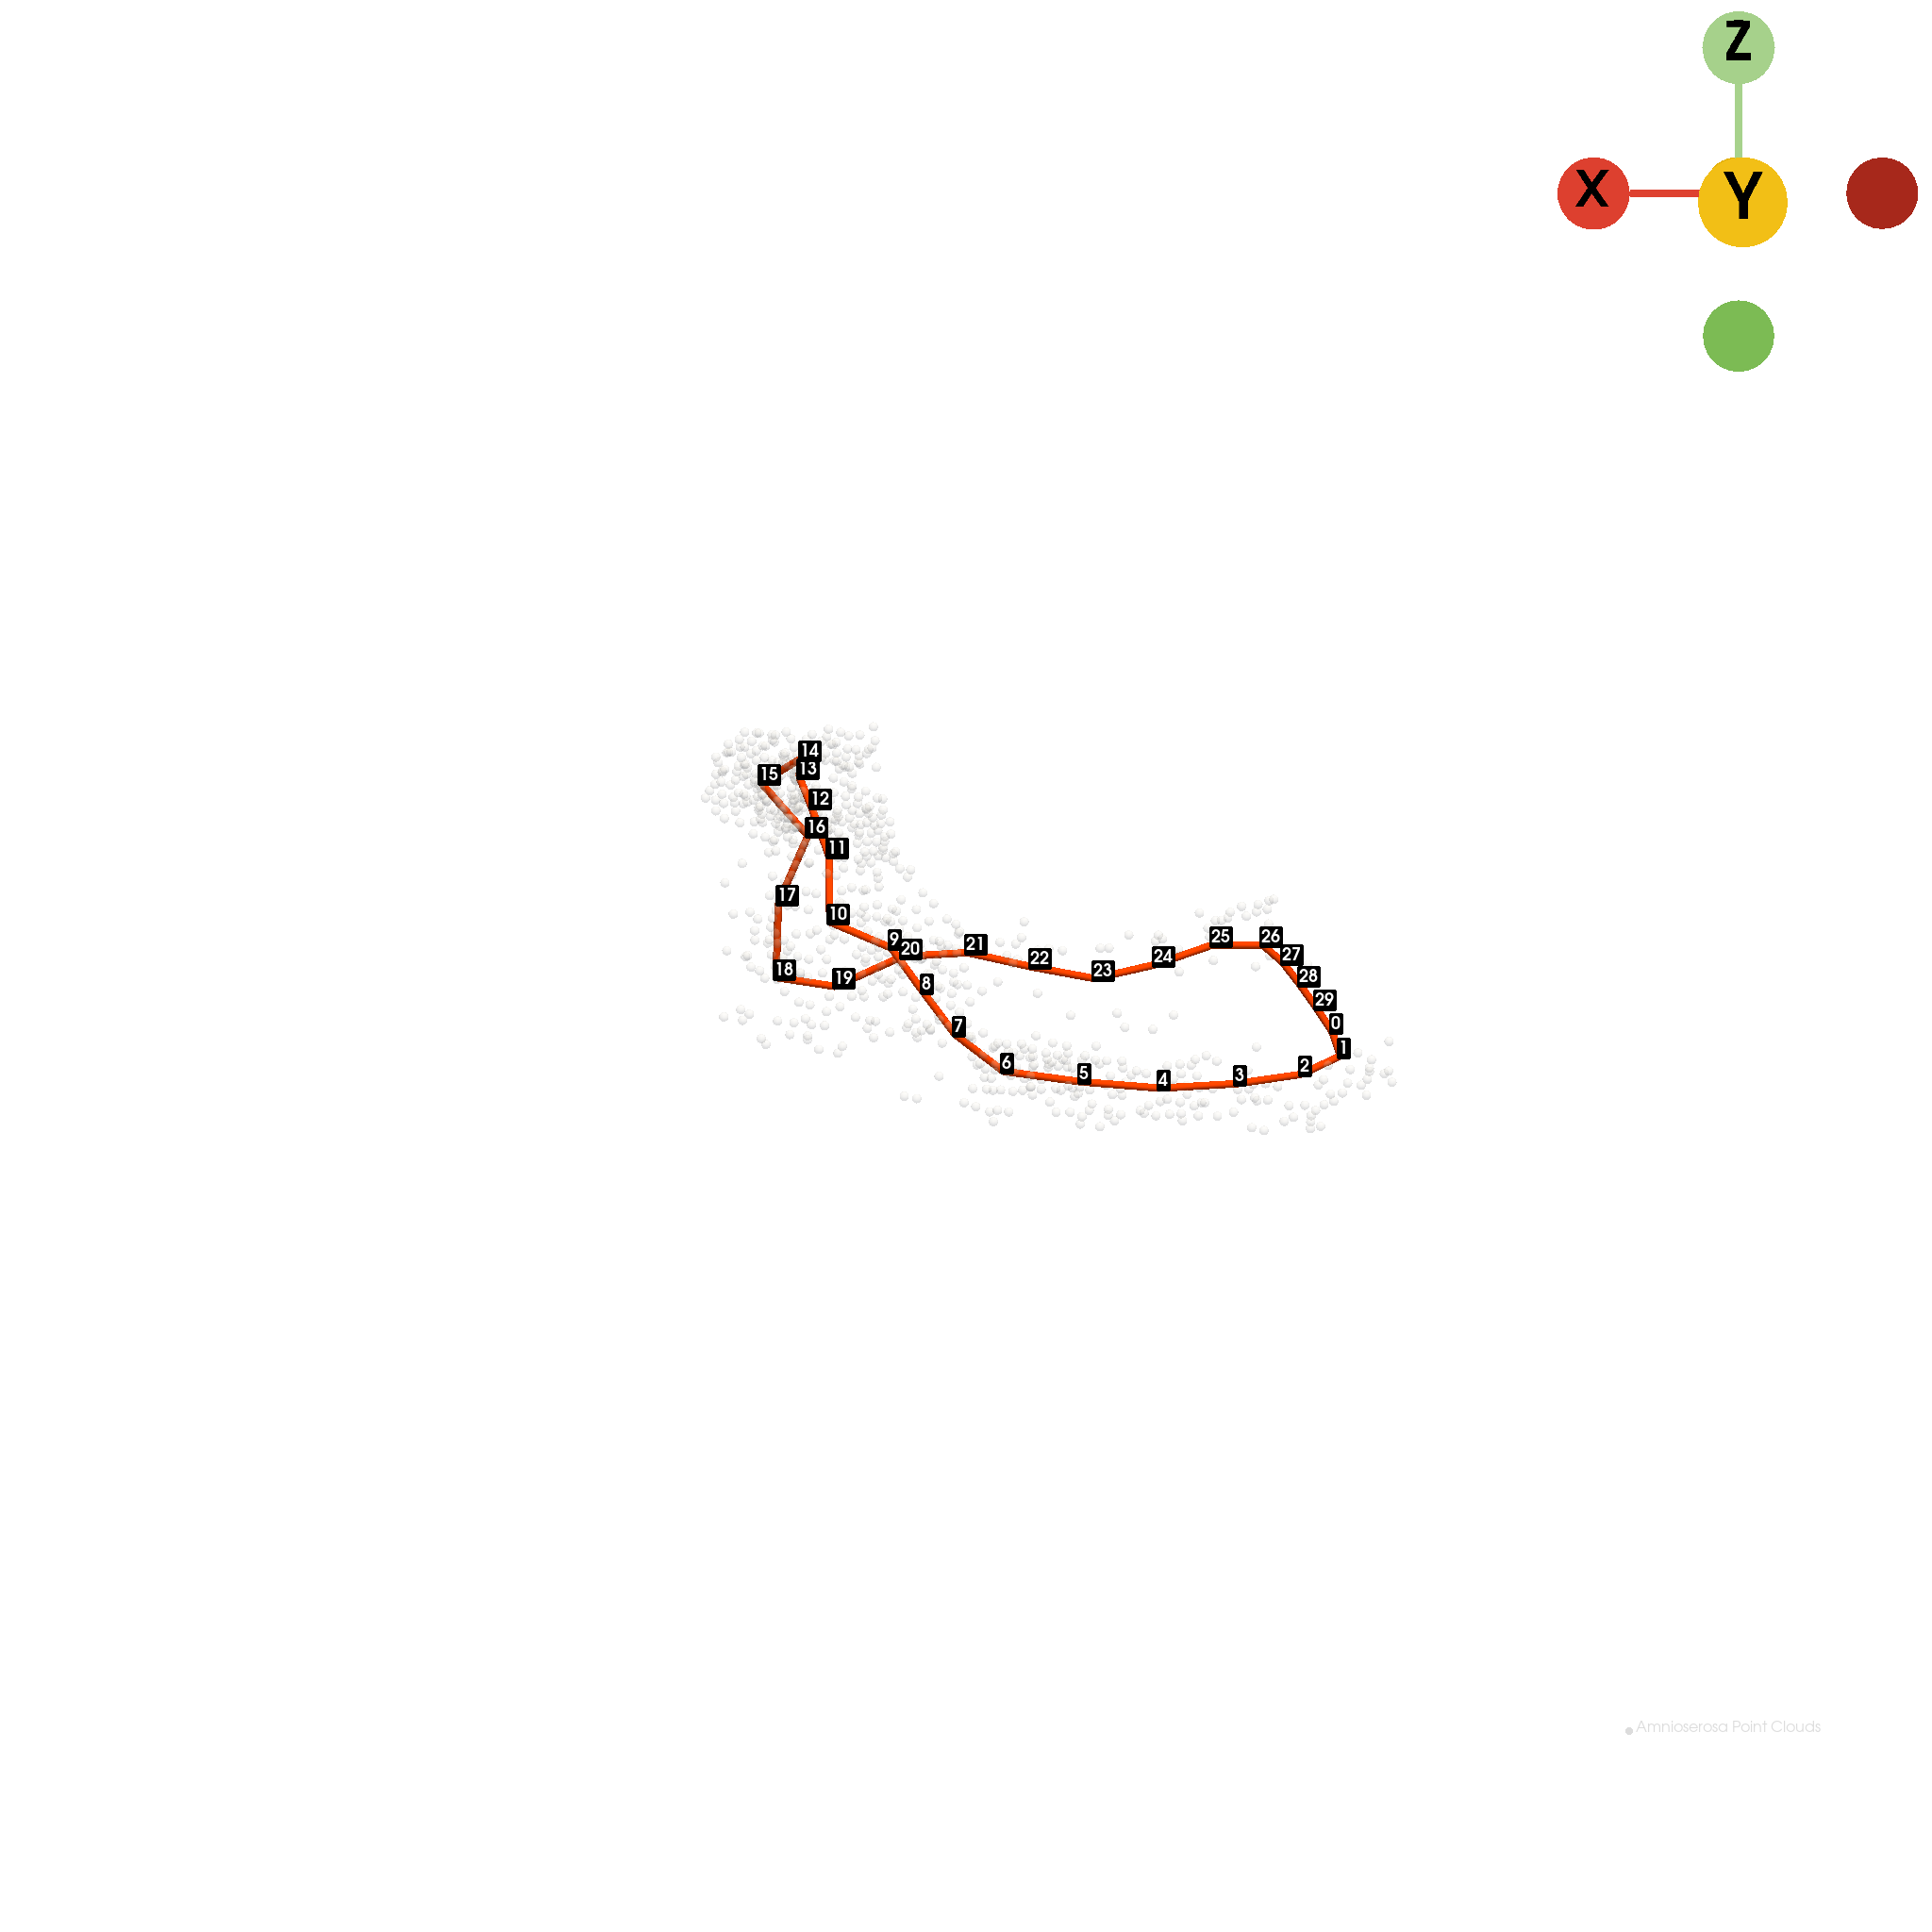

In [150]:
backbone, backbone_length, _ = st.tdr.construct_backbone(
    model=germ_voxel,
    color="orangered",
    rd_method="ElPiGraph",
    num_nodes=30,
    topology="circle",
    Mu = 0.01,
    Lambda=1e-2,
)
    
st.pl.backbone(
    backbone_model=backbone,
    bg_model=germ_pc,
    bg_key="backbone",
    jupyter="static",
    cpo=cpo,
    filename=os.path.join(out_image_path, f"{sample_id}_amnioserosa_backbone_model_raw_labels.pdf")
)

## Update backbone

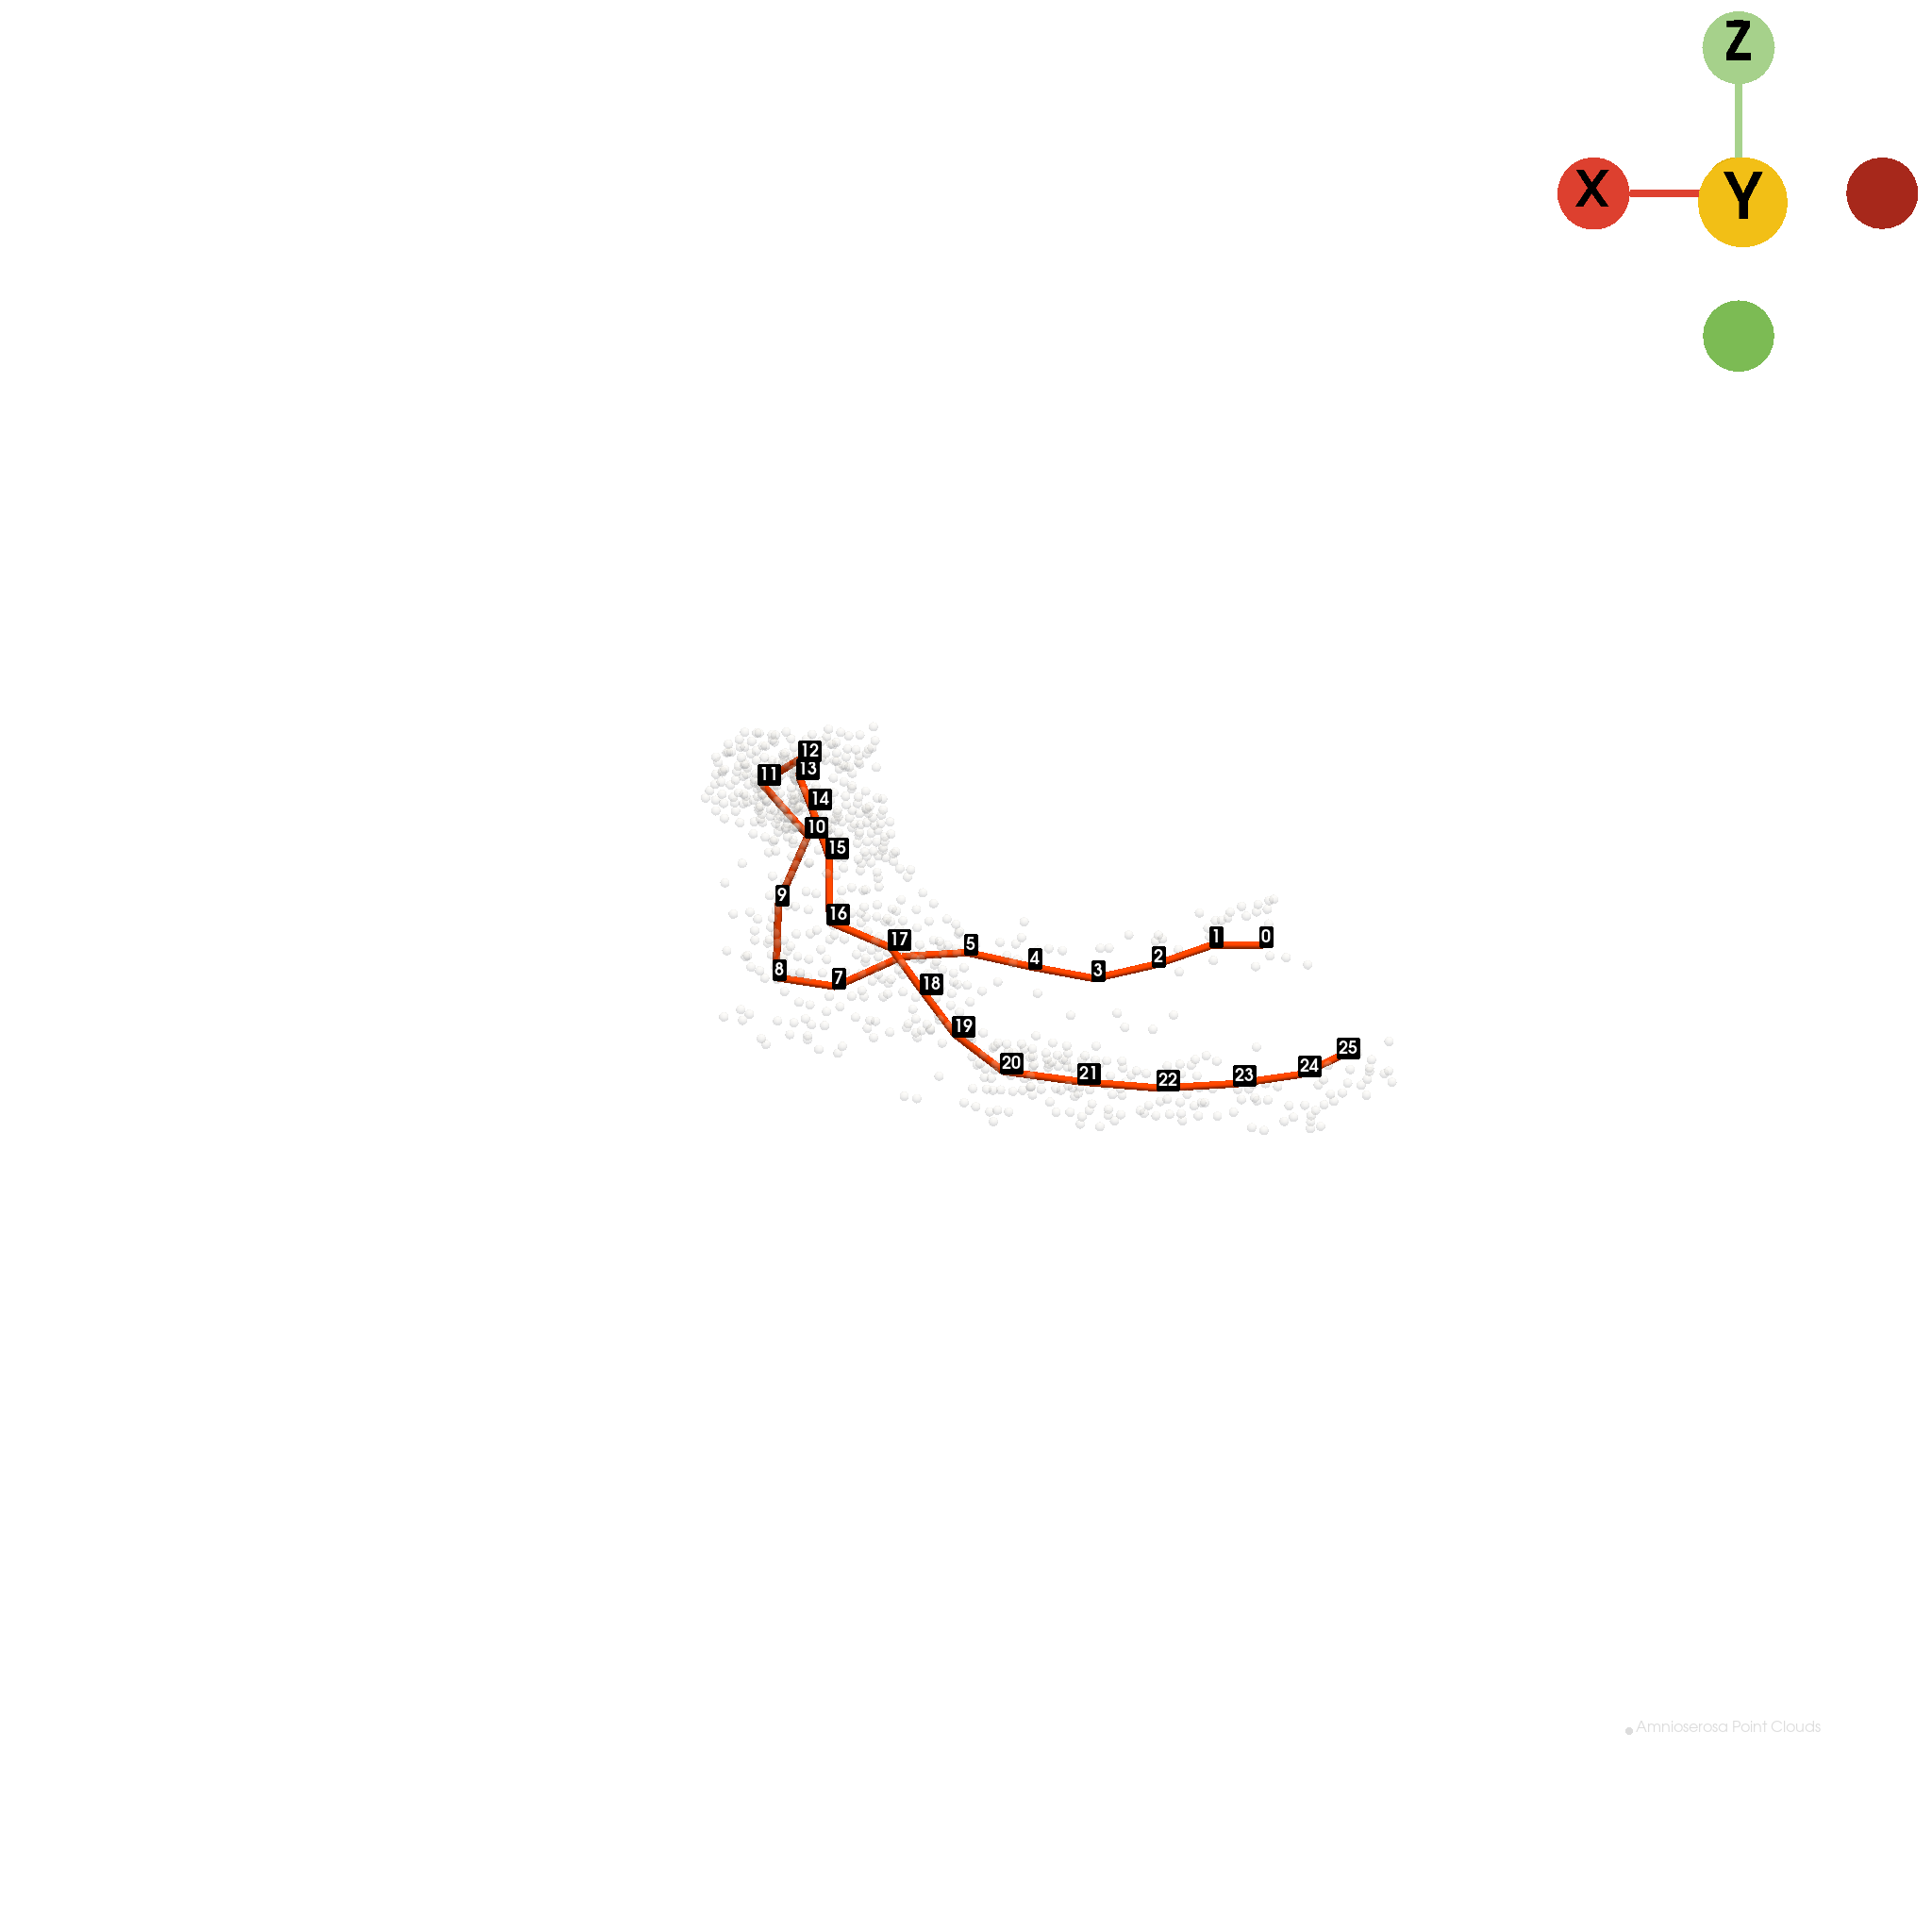

In [153]:
updated_backbone = st.tdr.update_backbone(backbone=backbone, interactive=True)
updated_backbone.point_data["updated_nodes"] = np.asarray([updated_backbone.n_points-1 - i for i in range(updated_backbone.n_points)])
st.pl.backbone(
    backbone_model=updated_backbone,
    bg_model=germ_pc,
    bg_key="backbone",
    nodes_key="updated_nodes",
    jupyter="static",
    cpo=cpo,
    filename=os.path.join(out_image_path, f"{sample_id}_amnioserosa_backbone_model_labels.pdf")
)

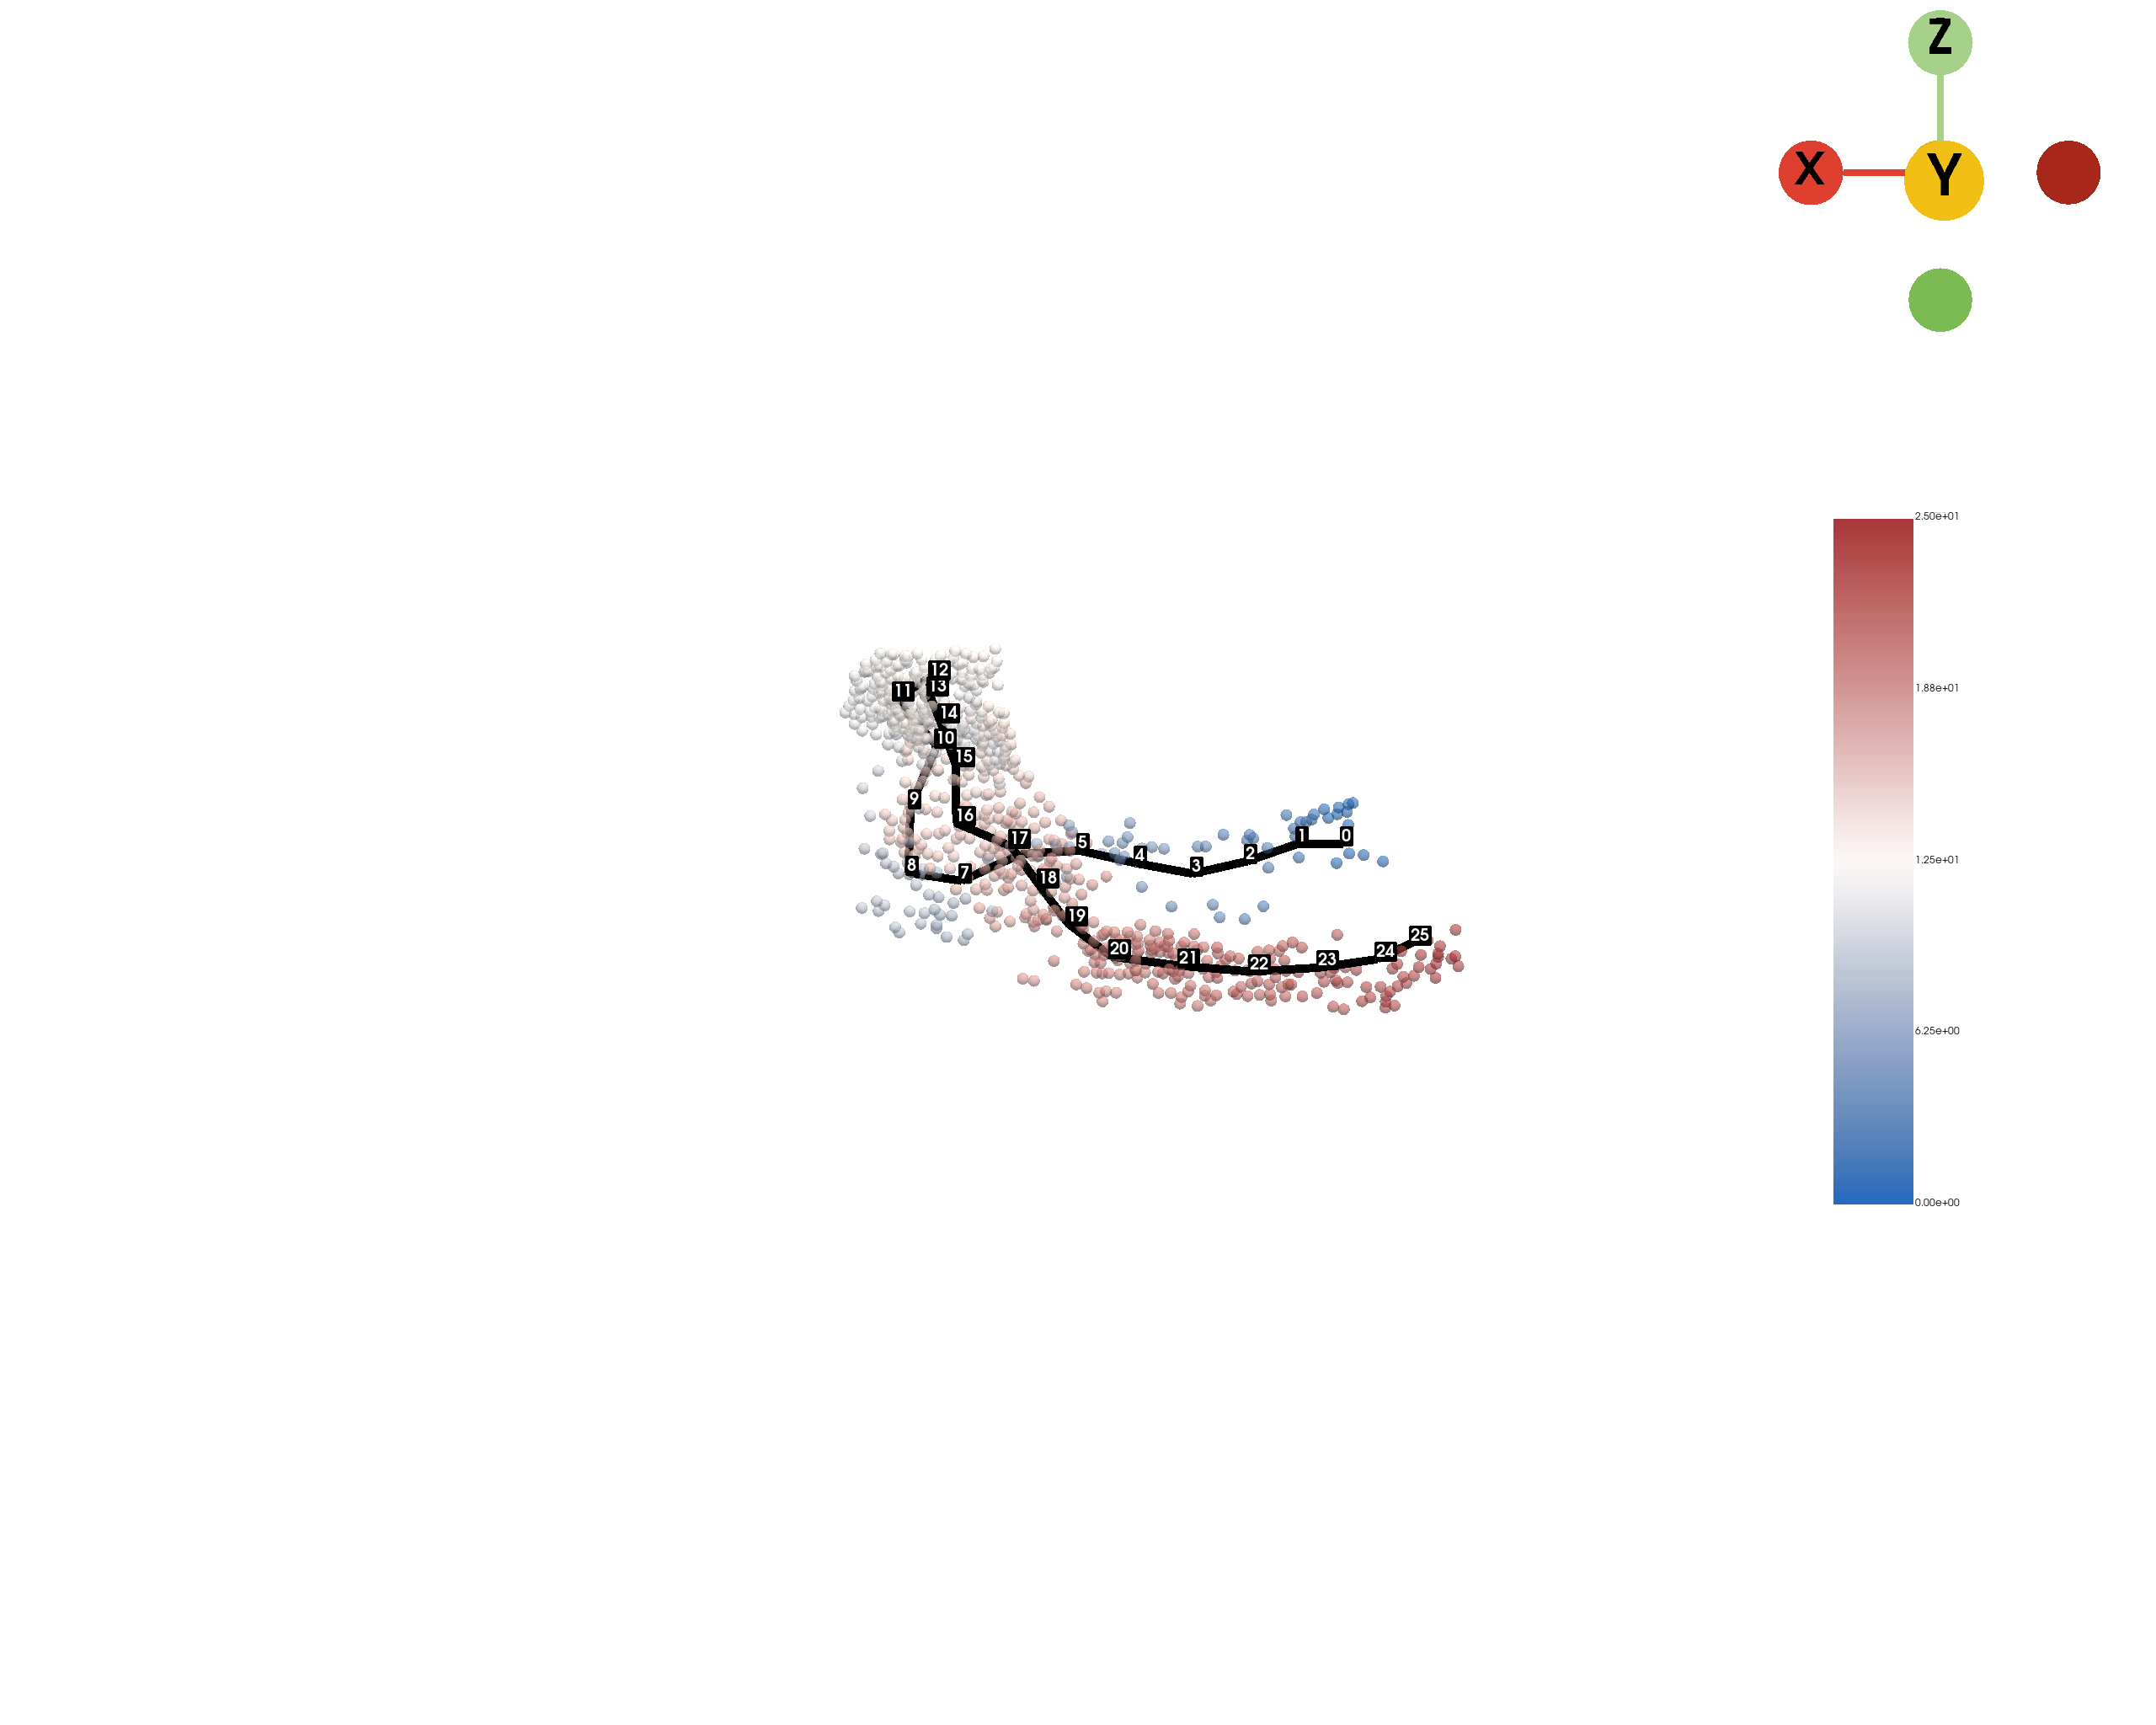

In [155]:
st.tdr.map_points_to_backbone(
    model=germ_pc,
    backbone_model=updated_backbone,
    nodes_key="updated_nodes",
    key_added="backbone_nodes",
    inplace=True,
)
st.pl.backbone(
    backbone_model=updated_backbone,
    backbone_model_size=10,
    backbone_key="updated_nodes",
    backbone_colormap="black",
    nodes_key="updated_nodes",
    nodes_label_size=20,
    bg_model=germ_pc,
    bg_key="backbone_nodes",
    bg_colormap="vlag",
    bg_model_size=14,
    bg_opacity=0.6,
    jupyter="static",
    cpo=cpo,
    window_size=(2560, 2048),
    filename=os.path.join(out_image_path, f"{sample_id}_amnioserosa_pc_backbone_model_with_labels.pdf")
)

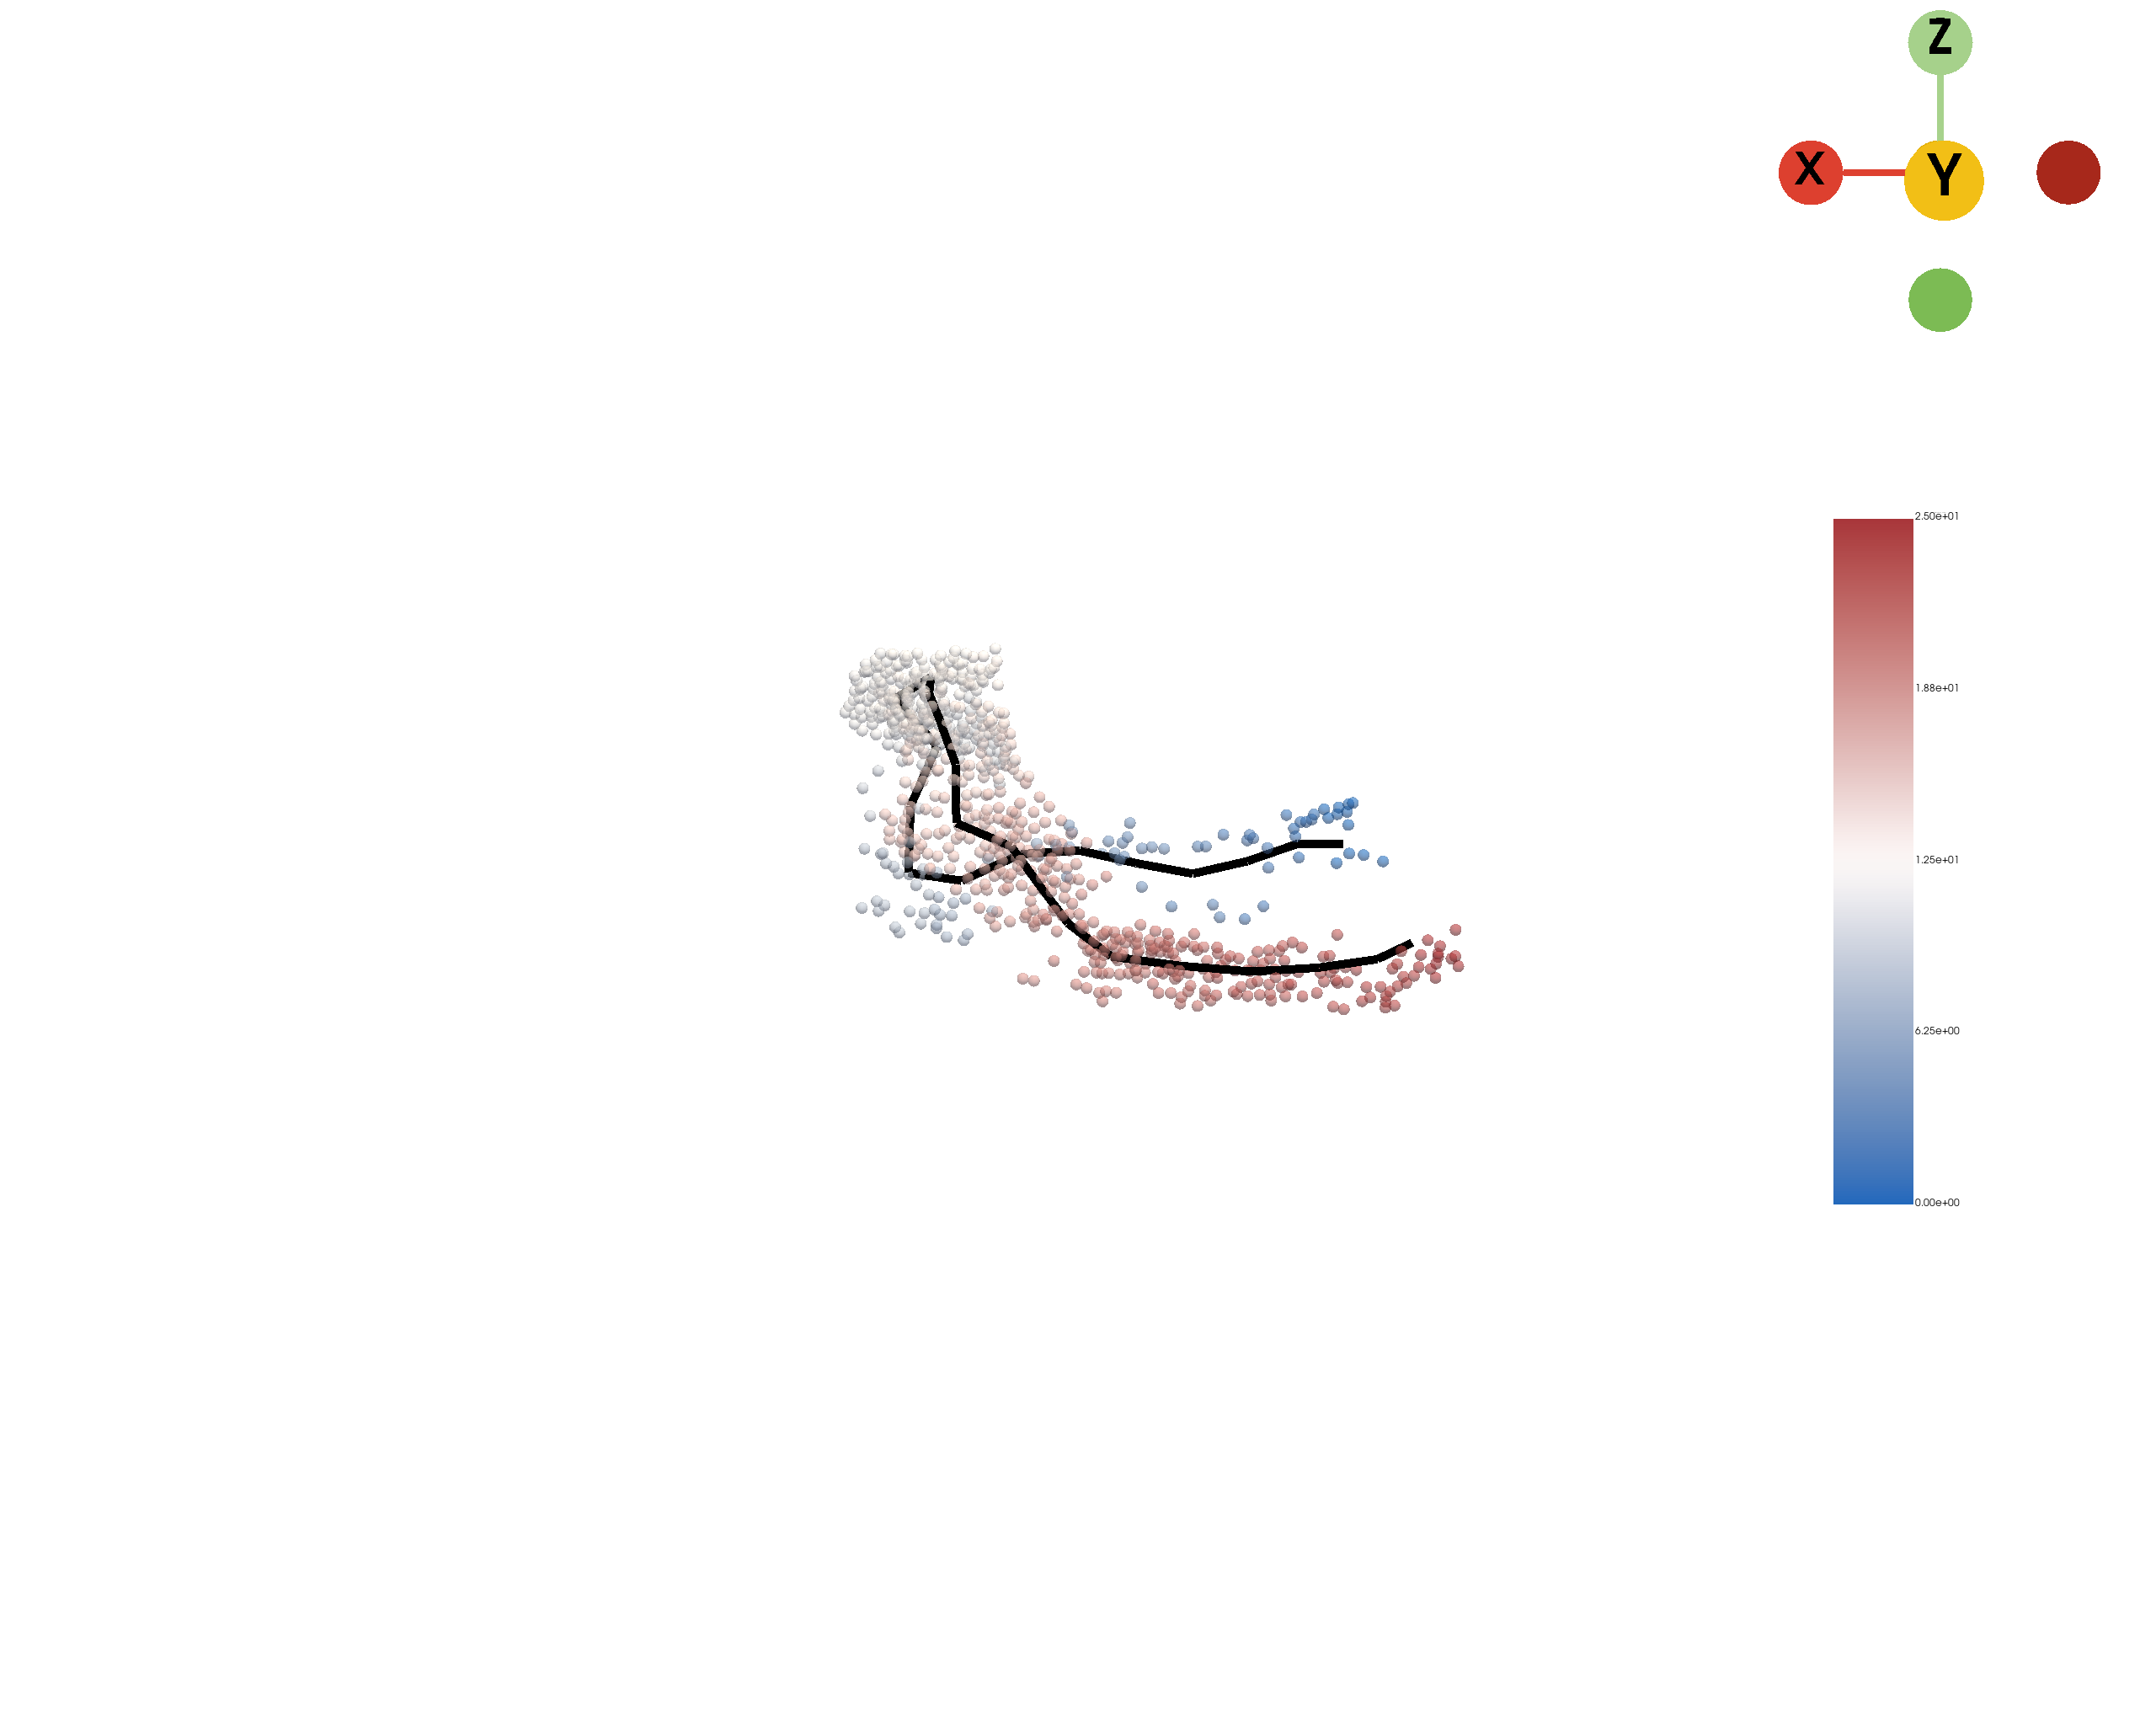

In [156]:
st.pl.backbone(
    backbone_model=updated_backbone,
    backbone_model_size=10,
    backbone_key="updated_nodes",
    backbone_colormap="black",
    nodes_key=None,
    bg_model=germ_pc,
    bg_key="backbone_nodes",
    bg_colormap="vlag",
    bg_model_size=14,
    bg_opacity=0.6,
    jupyter="static",
    cpo=cpo,
    window_size=(2560, 2048),
    filename=os.path.join(out_image_path, f"{sample_id}_amnioserosa_pc_backbone_model.pdf")
)

## Save backbone

In [157]:
obs_index = np.asarray(germ_pc.point_data["obs_index"])
germ_adata = germ_adata[obs_index, :].copy()
germ_adata.obs["backbone_nodes"] = np.asarray(germ_pc.point_data["backbone_nodes"])
germ_adata.X= germ_adata.layers["X_counts"].copy()
germ_adata.write_h5ad(f"h5ad/{sample_id}_amnioserosa_v2.h5ad", compression="gzip")

st.tdr.save_model(model=germ_pc, filename=f"pc_models/Amnioserosa__{sample_id}_aligned_pc_model.vtk")
st.tdr.save_model(model=updated_backbone, filename=f"pc_models/Amnioserosa__{sample_id}_aligned_backbone_model.vtk")
germ_adata

AnnData object with n_obs × n_vars = 769 × 6729
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'backbone_nodes'
    uns: '__type'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

## Cell difference along the backbone

In [18]:
germ_adata = st.read_h5ad(f"h5ad/{sample_id}_amnioserosa_v2.h5ad")
germ_pc = st.tdr.read_model(f"pc_models/Amnioserosa__{sample_id}_aligned_pc_model.vtk")
backbone = st.tdr.read_model(f"pc_models/Amnioserosa__{sample_id}_aligned_backbone_model.vtk")
germ_adata

AnnData object with n_obs × n_vars = 20424 × 8136
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'anno_germ_layer_new', 'backbone_nodes'
    uns: 'glm_degs', 'log1p'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

In [158]:
germ_adata.X= germ_adata.layers["X_counts"].copy()
sc.pp.normalize_total(germ_adata)
sc.pp.log1p(germ_adata)

In [159]:
st.tl.glm_degs(
    adata=germ_adata,
    fullModelFormulaStr=f'~cr(backbone_nodes, df=3)',
    key_added="glm_degs",
    qval_threshold=0.05,
    llf_threshold=0
)
print(germ_adata.uns["glm_degs"]["glm_result"])

|-----? Gene expression matrix must be normalized by the size factor, please check if the input gene expression matrix is correct.If you don't have the size factor normalized gene expression matrix, please run `dynamo.pp.normalize_cell_expr_by_size_factors(skip_log = True)`.
|-----> [Detecting genes via Generalized Additive Models (GAMs)] in progress: 100.0000%
|-----> [Detecting genes via Generalized Additive Models (GAMs)] finished [106.2666s]
               status family  log-likelihood          pval          qval
Obp56a             ok    NB2     -558.984558  8.762698e-13  1.441667e-11
lncRNA:CR43887     ok    NB2     -272.053375  1.407309e-08  2.171969e-07
Nmdmc              ok    NB2      -29.920658  5.402694e-06  8.823963e-05
BobA               ok    NB2     -193.682556  2.673074e-04  4.355233e-03
mRpS29             ok    NB2      -31.483690  3.021921e-04  4.911717e-03
wnd                ok    NB2      -33.384918  3.255807e-04  4.990506e-03
wun                ok    NB2      -41.3

In [161]:
glm_data = germ_adata.uns["glm_degs"]["glm_result"]
#glm_data= glm_data.loc[glm_data["log-likelihood"] >= -2500, :]
#glm_data= glm_data.loc[glm_data["pval"] <= 1e-10, :]
glm_data

,status,family,log-likelihood,pval,qval
Obp56a,ok,NB2,-558.984558,8.762698e-13,1.441667e-11
lncRNA:CR43887,ok,NB2,-272.053375,1.407309e-08,2.171969e-07
Nmdmc,ok,NB2,-29.920658,5.402694e-06,8.823963e-05
BobA,ok,NB2,-193.682556,2.673074e-04,4.355233e-03
mRpS29,ok,NB2,-31.483690,3.021921e-04,4.911717e-03
wnd,ok,NB2,-33.384918,3.255807e-04,4.990506e-03
wun,ok,NB2,-41.363979,4.579136e-04,7.051032e-03
NFAT,ok,NB2,-42.303520,6.388423e-04,1.035848e-02
sws,ok,NB2,-12.115377,6.917091e-04,1.077433e-02
Pdp1,ok,NB2,-78.407997,7.584202e-04,1.226781e-02


Saving figure to image/amnioserosa_backbone/E7_8h_amnioserosa_glm_degs_fit.pdf...
Done


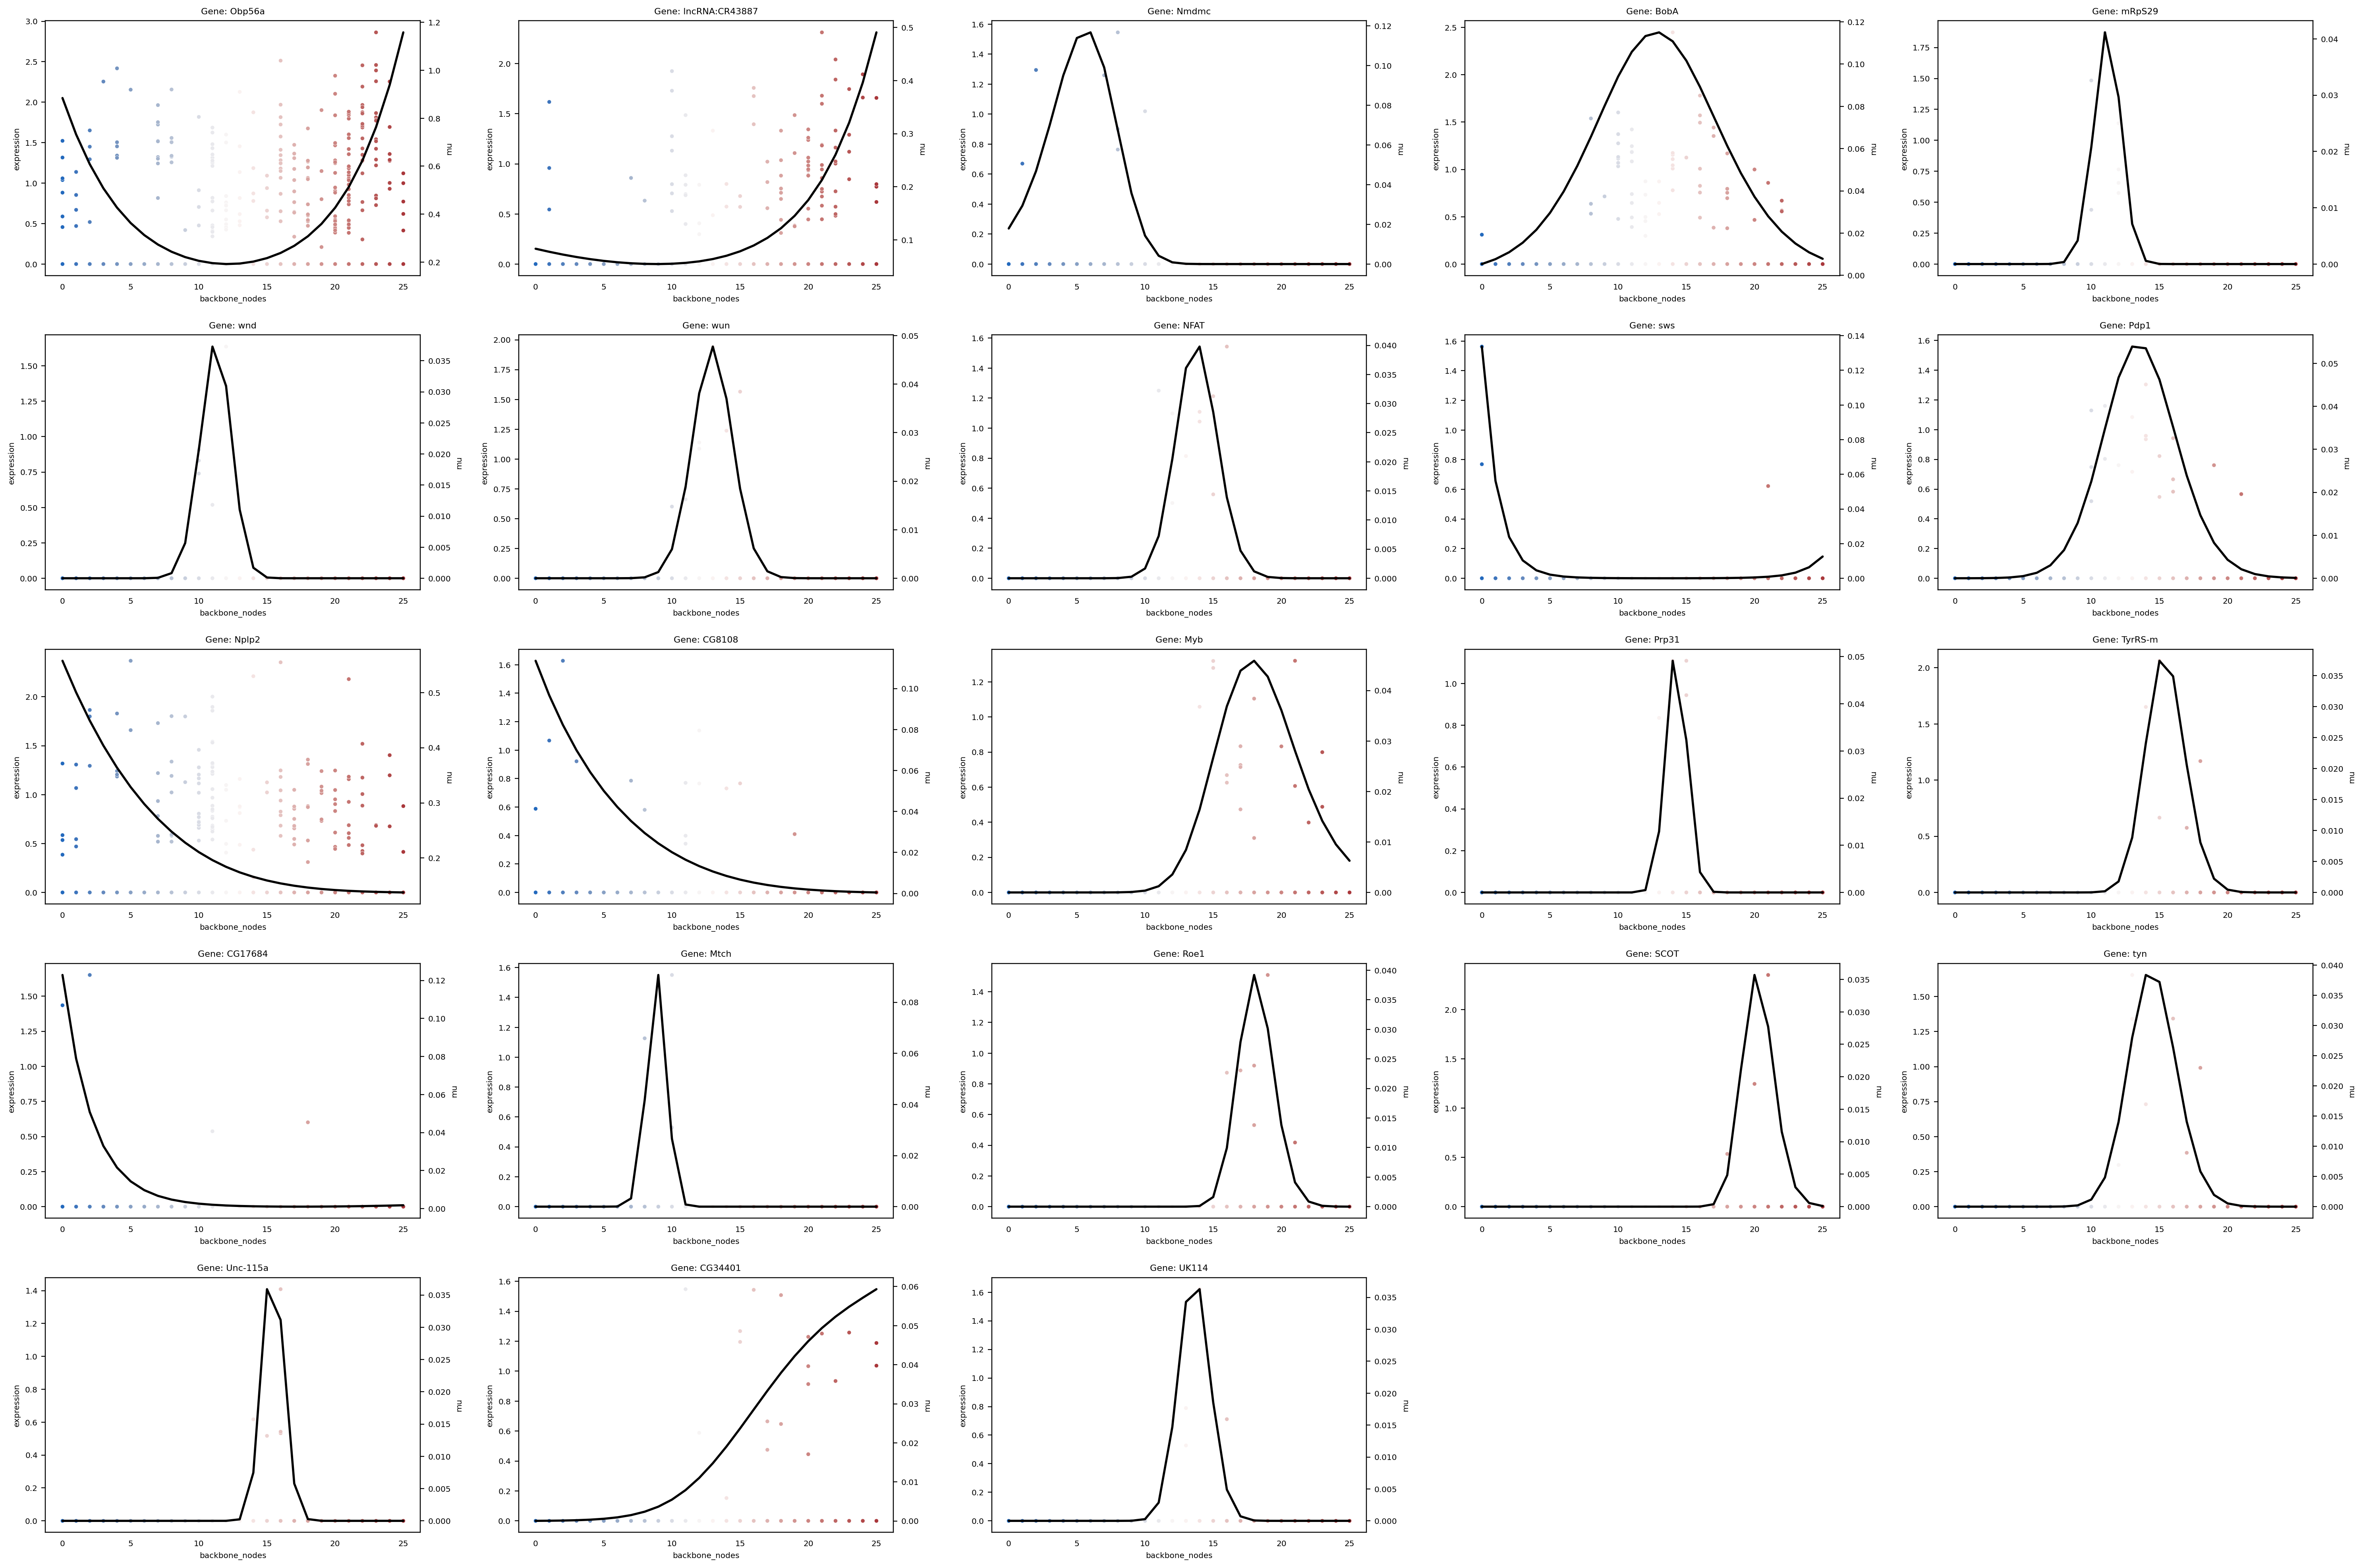

(<Figure size 3000x2000 with 46 Axes>,
 [<AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', ylabel='mu'>,
  <AxesSubplot:xlabel='backbone_nodes', yla

In [162]:
st.pl.glm_fit(
    adata=germ_adata,
    genes=glm_data.index.tolist(),
    ncols=5,
    feature_x="backbone_nodes",
    feature_y="expression",
    color_key="backbone_nodes",
    glm_key="glm_degs",
    show_legend=False,
    save_show_or_return="all",
    save_kwargs=dict(path=os.path.join(out_image_path, f"{sample_id}_amnioserosa_glm_degs_fit"), prefix=None, ext="pdf", dpi=300)
)

Saving figure to image/amnioserosa_backbone/E7_8h_amnioserosa_glm_degs_fit_heatmap_all.pdf...
Done
Saving figure to image/amnioserosa_backbone/E7_8h_amnioserosa_glm_degs_fit_heatmap.pdf...
Done


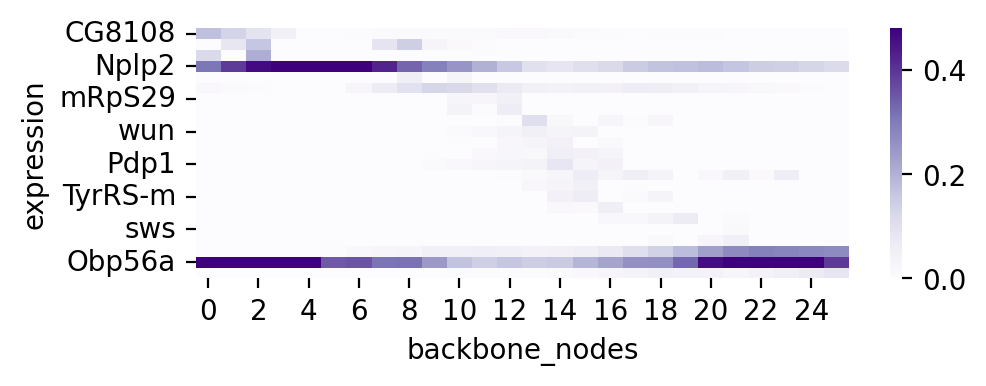

(<Figure size 600x200 with 2 Axes>,
 <AxesSubplot:xlabel='backbone_nodes', ylabel='expression'>)

In [164]:
st.pl.glm_heatmap(
    adata=germ_adata,
    genes=list(glm_data.index),
    feature_x = "backbone_nodes",
    feature_y = "expression",
    glm_key = "glm_degs",
    colormap= "Purples",
    frac=0.3,
    figsize = (6, 6),
    save_show_or_return="save",
    save_kwargs=dict(path=os.path.join(out_image_path, f"{sample_id}_amnioserosa_glm_degs_fit_heatmap_all"), prefix=None, ext="pdf", dpi=300)
)
st.pl.glm_heatmap(
    adata=germ_adata,
    genes=list(glm_data.index),
    feature_x = "backbone_nodes",
    feature_y = "expression",
    glm_key = "glm_degs",
    colormap= "Purples",
    frac=0.3,
    figsize = (6, 2),
    save_show_or_return="all",
    save_kwargs=dict(path=os.path.join(out_image_path, f"{sample_id}_amnioserosa_glm_degs_fit_heatmap"), prefix=None, ext="pdf", dpi=300)
)

## Genes

In [165]:
from typing import Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
from pyvista import PolyData, UniformGrid, UnstructuredGrid

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal


def add_model_labels(
    model: Union[PolyData, UnstructuredGrid, UniformGrid],
    labels: np.ndarray,
    key_added: str = "groups",
    where: Literal["point_data", "cell_data"] = "cell_data",
    colormap: Union[str, list, dict, np.ndarray] = "rainbow",
    alphamap: Union[float, list, dict, np.ndarray] = 1.0,
    mask_color: Optional[str] = "gainsboro",
    mask_alpha: Optional[float] = 0.0,
    inplace: bool = False,
) -> Tuple[Optional[PolyData or UnstructuredGrid], Optional[Union[str]]]:

        model = model.copy() if not inplace else model
        labels = np.asarray(labels).flatten()

        cu_arr = np.sort(np.unique(labels), axis=0).astype(object)
        raw_labels_hex = labels.copy().astype(object)
        raw_labels_alpha = labels.copy().astype(object)
        raw_labels_hex[raw_labels_hex == "mask"] = mpl.colors.to_hex(mask_color)
        raw_labels_alpha[raw_labels_alpha == "mask"] = mask_alpha

        # Set raw hex.
        if isinstance(colormap, str):
            if colormap in list(mpl.colormaps()):
                lscmap = mpl.cm.get_cmap(colormap)
                raw_hex_list = [mpl.colors.to_hex(lscmap(i)) for i in np.linspace(0, 1, len(cu_arr))]
                for label, color in zip(cu_arr, raw_hex_list):
                    raw_labels_hex[raw_labels_hex == label] = color
            else:
                raw_labels_hex[raw_labels_hex != "mask"] = mpl.colors.to_hex(colormap)
        elif isinstance(colormap, dict):
            for label, color in colormap.items():
                raw_labels_hex[raw_labels_hex == label] = mpl.colors.to_hex(color)
        elif isinstance(colormap, list) or isinstance(colormap, np.ndarray):
            raw_hex_list = np.array([mpl.colors.to_hex(color) for color in colormap]).astype(object)
            for label, color in zip(cu_arr, raw_hex_list):
                raw_labels_hex[raw_labels_hex == label] = color
        else:
            raise ValueError("`colormap` value is wrong." "\nAvailable `colormap` types are: `str`, `list` and `dict`.")

        # Set raw alpha.
        if isinstance(alphamap, float) or isinstance(alphamap, int):
            raw_labels_alpha[raw_labels_alpha != "mask"] = alphamap
        elif isinstance(alphamap, dict):
            for label, alpha in alphamap.items():
                raw_labels_alpha[raw_labels_alpha == label] = alpha
        elif isinstance(alphamap, list) or isinstance(alphamap, np.ndarray):
            raw_labels_alpha = np.asarray(alphamap).astype(object)
        else:
            raise ValueError(
                "`alphamap` value is wrong." "\nAvailable `alphamap` types are: `float`, `list` and `dict`."
            )

        # Set rgba.
        labels_rgba = [mpl.colors.to_rgba(c, alpha=a) for c, a in zip(raw_labels_hex, raw_labels_alpha)]
        labels_rgba = np.array(labels_rgba).astype(np.float32)

        # Added rgba of the labels.
        if where == "point_data":
            model.point_data[f"{key_added}_rgba"] = labels_rgba
        else:
            model.cell_data[f"{key_added}_rgba"] = labels_rgba

        plot_cmap = None

        # Added labels.
        if where == "point_data":
            model.point_data[key_added] = labels
        else:
            model.cell_data[key_added] = labels

        return model if not inplace else None, plot_cmap

In [166]:
GNs = glm_data.index
for gn in GNs:
    _gn = str(gn).replace(":", "_") if ":" in gn else gn

    pc_index = germ_pc.point_data["obs_index"].tolist()
    exp = germ_adata[pc_index, gn].X.A.flatten()
    exp[exp <= 0] = 0

    amap = exp.copy()
    amap = amap / np.max(amap)
    amap[amap <= 0.4] = 0.2
    add_model_labels(model=germ_pc, labels=exp, key_added=gn, alphamap=amap, where="point_data", inplace=True,
                     colormap="Purples")

    st.pl.three_d_plot(
        model=germ_pc,
        key=gn,
        model_style="points",
        model_size=14,
        opacity=1,
        colormap=None,
        show_legend=True,
        jupyter=False,
        off_screen=True,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_path, f"{sample_id}_amnioserosa_pc_model_{_gn}.pdf")
    )

## Reclustering

In [183]:
st.tdr.backbone_scc(
    adata=germ_adata,
    backbone=updated_backbone,
    genes=list(glm_data.index),
    resolution=0.6,
    e_neigh=8,
    s_neigh=8,
    layer="X_counts",
    inplace=True
)
germ_adata.obs["backbone_scc"] = germ_adata.obs["backbone_scc"].map(lambda x: int(x))
pc_index = germ_pc.point_data["obs_index"].tolist()
st.tdr.add_model_labels(model=germ_pc, labels=germ_adata.obs.loc[pc_index, "backbone_scc"], key_added="backbone_scc",
                        where="point_data", inplace=True, colormap="Spectral")
_ = st.pl.three_d_plot(
    model=germ_pc,
    key="backbone_scc",
    model_style="points",
    model_size=14,
    opacity=1,
    colormap="Spectral",
    show_legend=True,
    jupyter=False,
    cpo=cpo,
    window_size=(2560, 2048),
)

|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> using adj_matrix from arg for clustering...
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to igraph object
|-----> [Community clustering with leiden] completed [8.7875s]


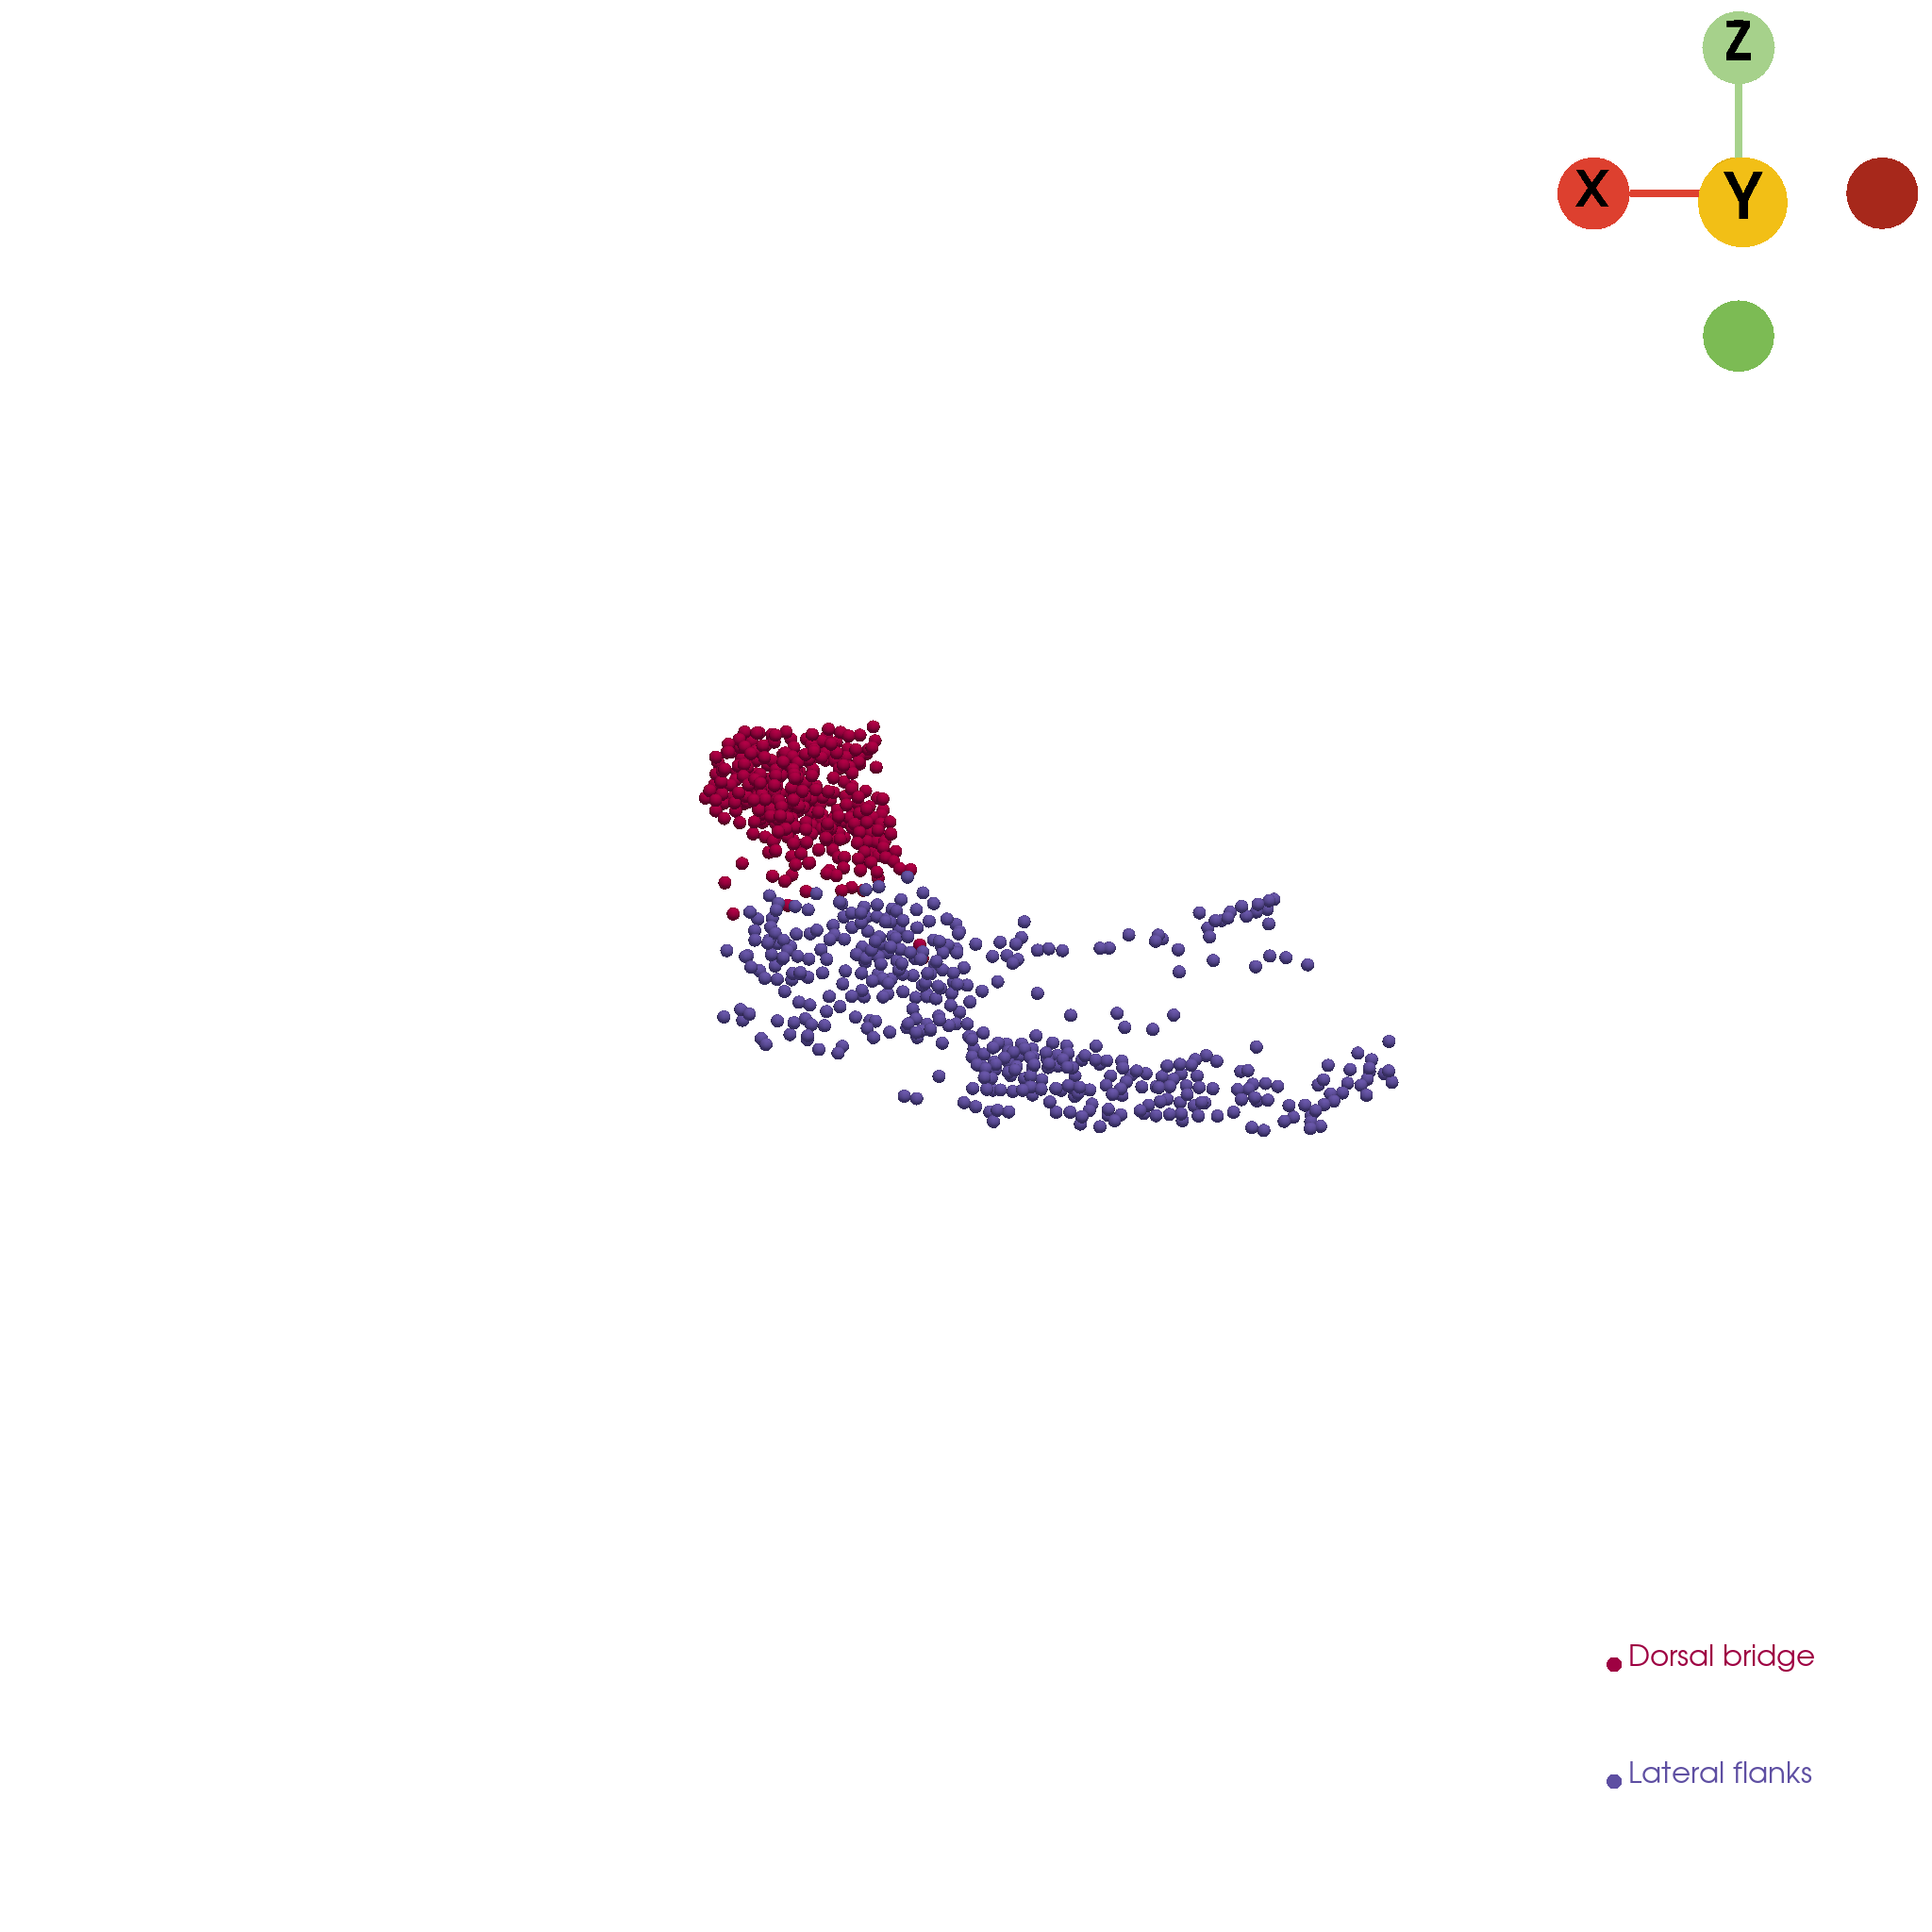

In [5]:
sorted_clustering = {0:"Lateral flanks", 1:"Dorsal bridge"}
germ_adata.obs["segments"] = germ_adata.obs["backbone_scc"].map(lambda x: sorted_clustering[int(x)])
pc_index = germ_pc.point_data["obs_index"].tolist()
st.tdr.add_model_labels(model=germ_pc, labels=germ_adata.obs.loc[pc_index, "segments"], key_added="segments", where="point_data", colormap="Spectral", inplace=True)
_ = st.pl.three_d_plot(
        model=germ_pc,
        key="segments",
        model_style="points",
        model_size=14,
        opacity=1,
        colormap=None,
        show_legend=True,
        jupyter="static",
        cpo=cpo,
        window_size=(2048, 2048),
        filename=os.path.join(out_image_path, f"{sample_id}_amnioserosa_segments_model.png")
    )

In [6]:
germ_adata.write_h5ad(f"h5ad/{sample_id}_amnioserosa_v3.h5ad", compression="gzip")
st.tdr.save_model(model=germ_pc, filename=f"pc_models/Amnioserosa_{sample_id}_aligned_pc_model.vtk")

## DEGs

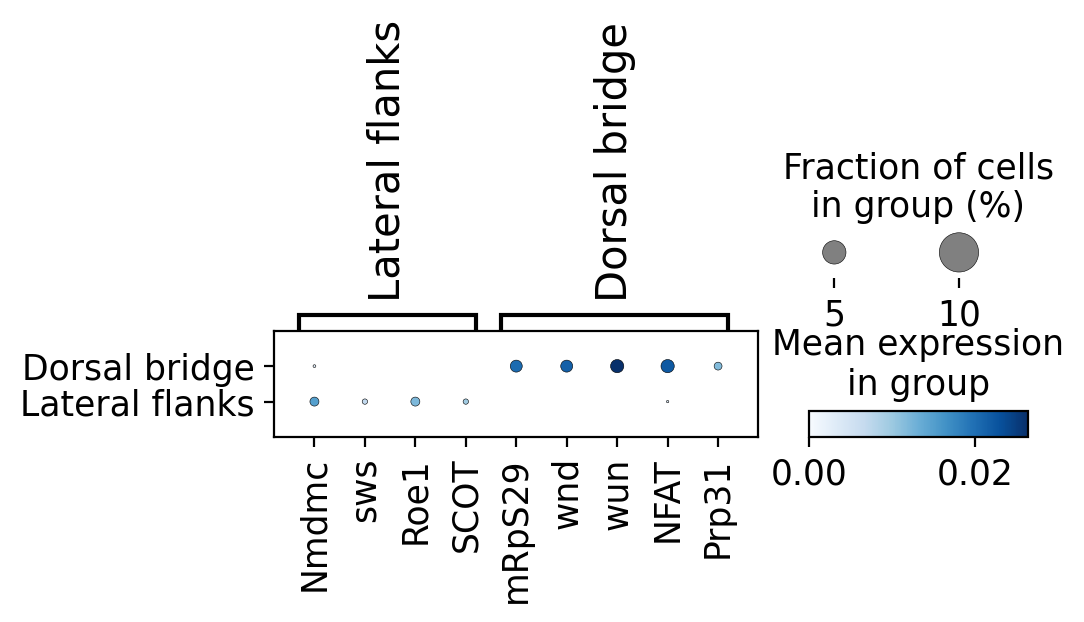

In [10]:
mkgs = {"Lateral flanks": ["Nmdmc", "sws", "Roe1", "SCOT"], "Dorsal bridge": ["mRpS29", "wnd", "wun", "NFAT", "Prp31"]}
sc.set_figure_params(frameon=False, dpi=100, dpi_save=300, fontsize=15)
sc.pl.dotplot(germ_adata, mkgs, groupby='segments', cmap='Blues', show=True)

In [11]:
import gseapy as gp

gp.get_library_name(organism="fly")

['Allele_LoF_Phenotypes_from_FlyBase_2017',
 'Allele_Phenotypes_from_FlyBase_2017',
 'Anatomy_AutoRIF',
 'Anatomy_AutoRIF_Predicted_zscore',
 'Anatomy_GeneRIF',
 'Anatomy_GeneRIF_Predicted_zscore',
 'Coexpression_Predicted_GO_Biological_Process_2018',
 'Coexpression_Predicted_GO_Cellular_Component_2018',
 'Coexpression_Predicted_GO_Molecular_Function_2018',
 'GO_Biological_Process_2018',
 'GO_Biological_Process_AutoRIF',
 'GO_Biological_Process_AutoRIF_Predicted_zscore',
 'GO_Biological_Process_GeneRIF',
 'GO_Biological_Process_GeneRIF_Predicted_zscore',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_AutoRIF',
 'GO_Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Cellular_Component_GeneRIF',
 'GO_Cellular_Component_GeneRIF_Predicted_zscore',
 'GO_Molecular_Function_2018',
 'GO_Molecular_Function_AutoRIF',
 'GO_Molecular_Function_AutoRIF_Predicted_zscore',
 'GO_Molecular_Function_GeneRIF',
 'GO_Molecular_Function_GeneRIF_Predicted_zscore',
 'Human_Disease_from_FlyBase_2017',
 

In [12]:
import gseapy as gp

save_folder = os.path.join(out_image_path, f"Lateral_flanks")
Path(save_folder).mkdir(parents=True, exist_ok=True)
# GO-biologial process
go_bp = gp.enrichr(
        gene_list=["Nmdmc", "sws", "Roe1", "SCOT"],
        gene_sets="GO_Biological_Process_2018",
        organism="fly",
        outdir=save_folder,
        no_plot=True,
        verbose=True
)

go_bp_results = pd.read_csv(os.path.join(save_folder, f"GO_Biological_Process_2018.fly.enrichr.reports.txt"), sep="\t")

gp.barplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2018', cutoff=0.05, top_term=50,
            figsize=(5, 20), ofname=os.path.join(save_folder, f"{sample_id}_Lateral_flanks_go_bp_selected_barplot.pdf"))
gp.dotplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2018', cmap='viridis_r',
           cutoff=0.05, top_term=50, figsize=(5, 20), ofname=os.path.join(save_folder, f"{sample_id}_Lateral_flanks_go_bp_selected_dotplot.pdf"))

2023-09-14 13:34:12,288 [INFO] Run: GO_Biological_Process_2018 
2023-09-14 13:34:15,575 [INFO] Save enrichment results for GO_Biological_Process_2018 
2023-09-14 13:34:15,577 [INFO] Done.


In [13]:
import gseapy as gp

save_folder = os.path.join(out_image_path, f"Dorsal_bridge")
Path(save_folder).mkdir(parents=True, exist_ok=True)
# GO-biologial process
go_bp = gp.enrichr(
        gene_list=["mRpS29", "wnd", "wun", "NFAT", "Prp31"],
        gene_sets="GO_Biological_Process_2018",
        organism="fly",
        outdir=save_folder,
        no_plot=True,
        verbose=True
)

go_bp_results = pd.read_csv(os.path.join(save_folder, f"GO_Biological_Process_2018.fly.enrichr.reports.txt"), sep="\t")

gp.barplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2018', cutoff=0.05, top_term=50,
            figsize=(5, 20), ofname=os.path.join(save_folder, f"{sample_id}_Dorsal_bridge_go_bp_selected_barplot.pdf"))
gp.dotplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2018', cmap='viridis_r',
           cutoff=0.05, top_term=50, figsize=(5, 20), ofname=os.path.join(save_folder, f"{sample_id}_Dorsal_bridge_go_bp_selected_dotplot.pdf"))

2023-09-14 13:36:02,572 [INFO] Run: GO_Biological_Process_2018 
2023-09-14 13:36:06,079 [INFO] Save enrichment results for GO_Biological_Process_2018 
2023-09-14 13:36:06,080 [INFO] Done.


In [188]:
germ_adata = germ_adata[germ_adata.layers["X_counts"].sum(axis=1) !=0, germ_adata.layers["X_counts"].sum(axis=0) !=0]
germ_adata.X = germ_adata.layers["X_counts"].copy()
germ_adata

View of AnnData object with n_obs × n_vars = 769 × 6729
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'backbone_nodes', 'backbone_scc', 'segments'
    uns: '__type', 'log1p', 'glm_degs', 'pp'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'